# Финальное задание

In [1]:
import json
import bz2

with bz2.BZ2File('./data/matches.jsonlines.bz2') as matches_file:
    for line in matches_file:
        match = json.loads(line.decode('utf-8'))
        
        # Обработка матча
        break

In [116]:
import pandas

df = pandas.read_csv('./data/features.csv', index_col='match_id')
df_test = pandas.read_csv('./data/features_test.csv', index_col='match_id')

df_test.shape, df.shape

((17177, 102), (97230, 108))

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

## Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки. Для этого нужно получать предсказания с помощью функции predict_proba. Она возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу. Вам нужны значения из второго столбца:
```python
pred = clf.predict_proba(X_test)[:, 1]
```

### Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. Какой столбец содержит целевую переменную? Запишите его название.
4. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?


##### Рекомендации и советы

- Если все работает очень медлено:
   - Используйте для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество — например, половину объектов. Подмножество лучше всего брать случайным, а не формировать его из первых m объектов.
   - Попробуйте упростить модель — например, уменьшить глубину деревьев в градиентом бустинге (max_depth).
   
##### Измерение времени работы кода
```python
import time
import datetime

start_time = datetime.datetime.now()

time.sleep(3) # вместо этой строчки разместить замеряемый код

print 'Time elapsed:', datetime.datetime.now() - start_time
```

In [43]:
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import roc_curve

In [32]:
counts = len(df)
empt_cols = desc.T[desc.T['count'] < counts]
for i in empt_cols.index:
    print(i)

first_blood_time
first_blood_team
first_blood_player1
first_blood_player2
radiant_bottle_time
radiant_courier_time
radiant_flying_courier_time
radiant_first_ward_time
dire_bottle_time
dire_courier_time
dire_flying_courier_time
dire_first_ward_time


In [57]:
#Избавляемся от пропусков в данных, данных соответствующих 
#результату матча и определяем целевую переменную
df = df.fillna(value=0.0)
X = df.loc[:,:'dire_first_ward_time']
y = df['radiant_win']

df_test = df_test.fillna(value=0.0)
X_test = df_test.loc[:,:]
X.shape, X_test.shape

((97230, 102), (17177, 102))

In [41]:
kf = KFold(n_splits=5, shuffle=True)

scores =[]


for k in [5,10,20,30,60,100]:
    print('-'*8 + str(k) + '-'*8)
    model = GradientBoostingClassifier(n_estimators=k)
    start_time = datetime.datetime.now()
    score = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
    print('Time elapsed: '+str( datetime.datetime.now() - start_time))
    print(score)
    scores.append(np.mean(score))

--------5--------
Time elapsed: 0:00:23.852643
[ 0.64538752  0.63341518  0.63161852  0.63063263  0.63336316]
--------10--------
Time elapsed: 0:00:39.378065
[ 0.6685008   0.66489537  0.6615558   0.66166809  0.66671503]
--------20--------
Time elapsed: 0:01:14.052930
[ 0.68438476  0.68330378  0.68303221  0.67957362  0.68123478]
--------30--------
Time elapsed: 0:01:50.506892
[ 0.68891566  0.68823837  0.69295156  0.68652823  0.6894174 ]
--------60--------
Time elapsed: 0:03:33.503482
[ 0.70279787  0.70341632  0.69691526  0.69818289  0.69875864]
--------100--------
Time elapsed: 0:05:44.361280
[ 0.70126917  0.70270667  0.71160199  0.71374851  0.70231076]


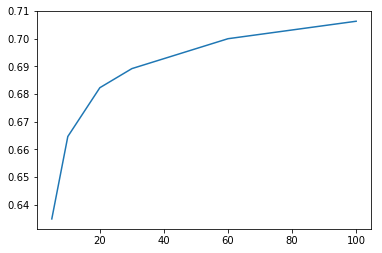

In [44]:
plt.plot([5,10,20,30,60,100],scores)
plt.show()

In [48]:
round(scores[3],2)

0.68999999999999995

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:01:50.
Показатель AUC-ROC в таком случае равен 0.69.

Увеличение количества деревьев увеличивает показатель метрики, приближая его к 0.71. Для достижения большего качества необходимо использовать более 30 деревьев. Для ускорения обучения можно использовать не всю выборку. Также можно уменьшить глубину деревьев (max_depth).

In [59]:
model = GradientBoostingClassifier(n_estimators=30)
model.fit(X,y)

y_pred_grad_proba = model.predict_proba(X_test)[:,1]

In [60]:
Submition = pandas.DataFrame( y_pred_grad_proba, index=df_test.index, columns=['radiant_win'])

In [61]:
Submition.to_csv('Submitions_grad.csv')
#kaggle 0.69370

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?


##### Код для формирования "мешка слов" по героям
```python
# N — количество различных героев в выборке
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
```

In [6]:
import time
import datetime
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

In [121]:
df = df.fillna(value=0.0)
X = df.loc[:,:'dire_first_ward_time']
y = df['radiant_win']

df_test = df_test.fillna(value=0.0)
X_test = df_test.loc[:,:]
print(X.shape, X_test.shape)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

(97230, 102) (17177, 102)


In [122]:
kf = KFold(n_splits=5, shuffle=True)


def test_model(X,y):
    scores =[]
    
    range_k = np.power(10.0, np.arange(-5, 6))
    
    for k in range_k:
        print('-'*8 + str(k) + '-'*8)
        start_time = datetime.datetime.now()
        model = LogisticRegression(C=k)
        score = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
        print('Time elapsed: '+str( datetime.datetime.now() - start_time))
        print(score)
        scores.append(np.mean(score))
    
    Max=max(scores)
    Max_index = scores.index(Max)
    
    return range_k[Max_index], round(Max,3)

In [123]:
C, score = test_model(X_train_scaled,y)

--------1e-05--------
Time elapsed: 0:00:03.499116
[ 0.69638315  0.69832964  0.69365305  0.69435708  0.69299967]
--------0.0001--------
Time elapsed: 0:00:05.618428
[ 0.70675038  0.71686095  0.70817549  0.71157504  0.71278496]
--------0.001--------
Time elapsed: 0:00:10.344717
[ 0.72076713  0.71770778  0.71087726  0.71512547  0.71587189]
--------0.01--------
Time elapsed: 0:00:13.927616
[ 0.71690022  0.71700821  0.7148096   0.7178491   0.71591466]
--------0.1--------
Time elapsed: 0:00:14.965193
[ 0.71504853  0.72033329  0.72216766  0.70890604  0.71543625]
--------1.0--------
Time elapsed: 0:00:16.190581
[ 0.71648355  0.71112644  0.71812924  0.71823939  0.71857535]
--------10.0--------
Time elapsed: 0:00:15.466256
[ 0.71725459  0.71279004  0.72349897  0.71543691  0.71331731]
--------100.0--------
Time elapsed: 0:00:14.932920
[ 0.71749331  0.7108517   0.71404074  0.7214228   0.71820759]
--------1000.0--------
Time elapsed: 0:00:16.093580
[ 0.71408219  0.72023825  0.71049615  0.72196776 

In [124]:
model = LogisticRegression(C=C)
model.fit(X_train_scaled,y)

y_pred_leinar = model.predict_proba(X_test_scaled)[:,1]

In [126]:
Submition_linear = pandas.DataFrame(y_pred_leinar, index=df_test.index, columns=['radiant_win'])
Submition_linear.to_csv('LinearSubmit.csv')
#kaggle 0.63718

In [127]:
print(C,score)

1.0 0.717


Наилучшее значение метрики для логистической регрессии равно 0.717, время затраченное на кросс-валидацию 0:00:16, сравнимо по качеству с 100 деревьями, но заметно быстрее (время которосе соответсвует валидации 0:05:44)

# Удаление категориальных признаков

In [117]:
hero = pandas.read_csv('./data/dictionaries/heroes.csv')
N = len(hero) # N — количество различных героев в выборке

def create_word_bug(data, N = N):
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(5):
            X_pick[i, data.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
    
    return X_pick

In [118]:
x_bug = create_word_bug(df)
x_bug_test = create_word_bug(df_test)

In [128]:
x_bug.shape, x_bug_test.shape

((97230, 112), (17177, 112))

In [129]:
del_col = ['lobby_type','r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
           'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

for x in del_col:
    del df[x]
    del df_test[x]

In [130]:
df = df.fillna(value=0.0)

X_without_categ = df.loc[:,:'dire_first_ward_time']

y_without_categ = df['radiant_win']

df_test = df_test.fillna(value=0.0)
X_without_categ_test = df_test.loc[:,:]

print(X_without_categ_test.shape, X_without_categ.shape)
scaler = StandardScaler()

X1_train_scaled = scaler.fit_transform(X_without_categ)
X1_test_scaled = scaler.transform(X_without_categ_test)

(17177, 91) (97230, 91)


In [131]:
kf = KFold(n_splits=5, shuffle=True)

C, score = test_model(X1_train_scaled,y1)
print(C,score)

--------1e-05--------
Time elapsed: 0:00:03.554297
[ 0.7008397   0.6947501   0.69248264  0.69278337  0.69474459]
--------0.0001--------
Time elapsed: 0:00:05.805863
[ 0.71944459  0.70763148  0.70918657  0.70719668  0.71285565]
--------0.001--------
Time elapsed: 0:00:11.241876
[ 0.71653413  0.7163499   0.71326101  0.71400065  0.72054755]
--------0.01--------
Time elapsed: 0:00:15.328547
[ 0.71610883  0.71293029  0.71488506  0.71929416  0.71814613]
--------0.1--------
Time elapsed: 0:00:15.088820
[ 0.71340627  0.72524193  0.71554902  0.71632181  0.71234652]
--------1.0--------
Time elapsed: 0:00:16.536643
[ 0.71813453  0.71693712  0.71759667  0.71586333  0.71397463]
--------10.0--------
Time elapsed: 0:00:15.207366
[ 0.71508663  0.71782233  0.71764414  0.71914889  0.71147369]
--------100.0--------
Time elapsed: 0:00:16.570414
[ 0.72130242  0.71360031  0.71481799  0.71669379  0.71596055]
--------1000.0--------
Time elapsed: 0:00:14.787248
[ 0.71403433  0.72056381  0.71682097  0.71552982 

In [132]:
model = LogisticRegression(C=C)
model.fit(X1_train_scaled,y1)

y_pred_leinar = model.predict_proba(X1_test_scaled)[:,1]

In [133]:
Submition_linear = pandas.DataFrame(y_pred_leinar, index=df_test.index, columns=['radiant_win'])
Submition_linear.to_csv('LinearSubmit.csv')
#kaggle 0.63718

Удаление категориальных признаков не привело к улучшению предсказания.Можно сделать вывод, что категореальные признаки не влияли на предсказание. Наилучшее значение метрики ROC-AUC 0.717, С = 0.1


# Создание мешка слов

In [138]:
scaler = StandardScaler()
X_bug = np.hstack((X_without_categ, x_bug))
X_bug_test = np.hstack((X_without_categ_test, x_bug_test))
x_word_bug = scaler.fit_transform(X_bug)
x_word_bug_tes = scaler.transform(X_bug_test)
x_word_bug_tes.shape,x_word_bug.shape

((17177, 203), (97230, 203))

In [136]:
kf = KFold(n_splits=5, shuffle=True)

C, score = test_model(x_word_bug,y1)
print(C,score)

--------1e-05--------
Time elapsed: 0:00:05.211843
[ 0.71194391  0.71434461  0.71201654  0.71917776  0.71717338]
--------0.0001--------
Time elapsed: 0:00:18.056795
[ 0.74088324  0.73507826  0.75059652  0.74735374  0.73989686]
--------0.001--------
Time elapsed: 0:00:16.938735
[ 0.74762696  0.75004275  0.7513205   0.75563464  0.75310365]
--------0.01--------
Time elapsed: 0:00:23.914411
[ 0.75178738  0.75103508  0.75180647  0.75221462  0.75209782]
--------0.1--------
Time elapsed: 0:00:25.758643
[ 0.75151209  0.75433006  0.75528228  0.75195363  0.74536417]
--------1.0--------
Time elapsed: 0:00:25.528520
[ 0.7545011   0.74668174  0.74891679  0.75117027  0.75731644]
--------10.0--------
Time elapsed: 0:00:25.301033
[ 0.75021506  0.75030287  0.75223479  0.75560214  0.75170446]
--------100.0--------
Time elapsed: 0:00:25.289009
[ 0.74940624  0.7538987   0.75588906  0.75357628  0.74655568]
--------1000.0--------
Time elapsed: 0:00:25.369614
[ 0.75321718  0.75168536  0.75054132  0.74829089 

In [139]:
model = LogisticRegression(C=C)
model.fit(x_word_bug, y1)

y_pred_leinar_word_bug = model.predict_proba(x_word_bug_tes)[:,1]

In [140]:
Submition_linear_bug = pandas.DataFrame(y_pred_leinar_word_bug, index=df_test.index, columns=['radiant_win'])
Submition_linear_bug.to_csv('Submition_linear_bug.csv')
#kaggle 0.75528

Добавление мешка слов улучшает качество предсказния модели результат на kaggle 0.75528 что выше по сравнению с предыдущими результатами (<0.7). Дання модель имеет наилучшее занчение метрики ROC-AUC при С = 10.0 , 0.752. Наихудшее значение метрики полученно для градиентного бустинга 0,71